In [1]:
# LOAD STATES and worm
%load_ext autoreload
%autoreload 2
import os
import re


import numpy as np
import tmputil as util

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.style.use('default')

import preprocessing as preworm
import tmputil_plots as tplot


In [2]:
bpath = os.getcwd()
dir_worm_file_list = os.path.join(bpath,'results_strains/worm_files_lists')
dir_datastore = os.path.split(dir_worm_file_list)[0]

In [3]:
strain_types = ['AQ2947','CB4852','CB4853','ED3017','ED3021','ED3054','N2']
strain_type = strain_types [6]

In [4]:
file_name_worms = os.path.join(dir_datastore,'extracted_aus_'+strain_type+'.npz')
names_of_worms =  np.load(file_name_worms)['worm_files']

In [5]:
fname_pdata = 'pdata.npz'
angles = []
all_x =[]
all_y =[]
for data in names_of_worms:
    worm_file = re.sub('/','--',data[:-4])
    angleArray =np.load(os.path.join(dir_datastore,worm_file,fname_pdata))['angleArray']
    all_x.append(np.load(os.path.join(dir_datastore,worm_file,fname_pdata))['x'])
    all_y.append(np.load(os.path.join(dir_datastore,worm_file,fname_pdata))['y'])
    angles.append(angleArray)

In [6]:
# force angles to have same length
common_ = min([max(x) for x in list(map(np.shape,angles))])
angles_trun = []
for angle in angles:
    angles_trun.append(angle[:common_,:])
worms_angleArray = np.vstack(angles_trun)
eigval_all, eigvec_all =preworm.worm_covariance(worms_angleArray)
eigAmps = np.dot(eigvec_all.T,worms_angleArray.T)
au = util.eig_normalization(eigAmps)

We are going to omit 0 angles


In [7]:
# Concatenate all eigenAmps
locations = np.arange(1,len(names_of_worms))*int(au.shape[1]/len(names_of_worms))
au_list=np.hsplit(au,locations)
time_frames = list(map(np.max,list(map(np.shape,au_list))))
eigAmps_list = np.hsplit(eigAmps,locations)

In [8]:
store = True
if store:
    f_out = os.path.join(dir_datastore,'joint_eigAmps_'+strain_type+'.npz')
    if not os.path.exists(f_out):
        np.savez(f_out,eigAmps=eigAmps_list,worm_files=names_of_worms,
                 time_frames=time_frames)
    else:
        print('File\n{}\nalready exists'.format(f_out))

File
/home/ekellbuch/Projects/behworm/arhmm-celegans/results_strains/joint_eigAmps_N2.npz
already exists


In [9]:
if store:
    f_out = os.path.join(dir_datastore,'joint_aus_'+strain_type+'.npz')
    if not os.path.exists(f_out):
        np.savez(f_out, aus=au_list,worm_files=names_of_worms,
                 time_frames=time_frames)
    else:
        print('File\n{}\nalready exists'.format(f_out))

File
/home/ekellbuch/Projects/behworm/arhmm-celegans/results_strains/joint_aus_N2.npz
already exists


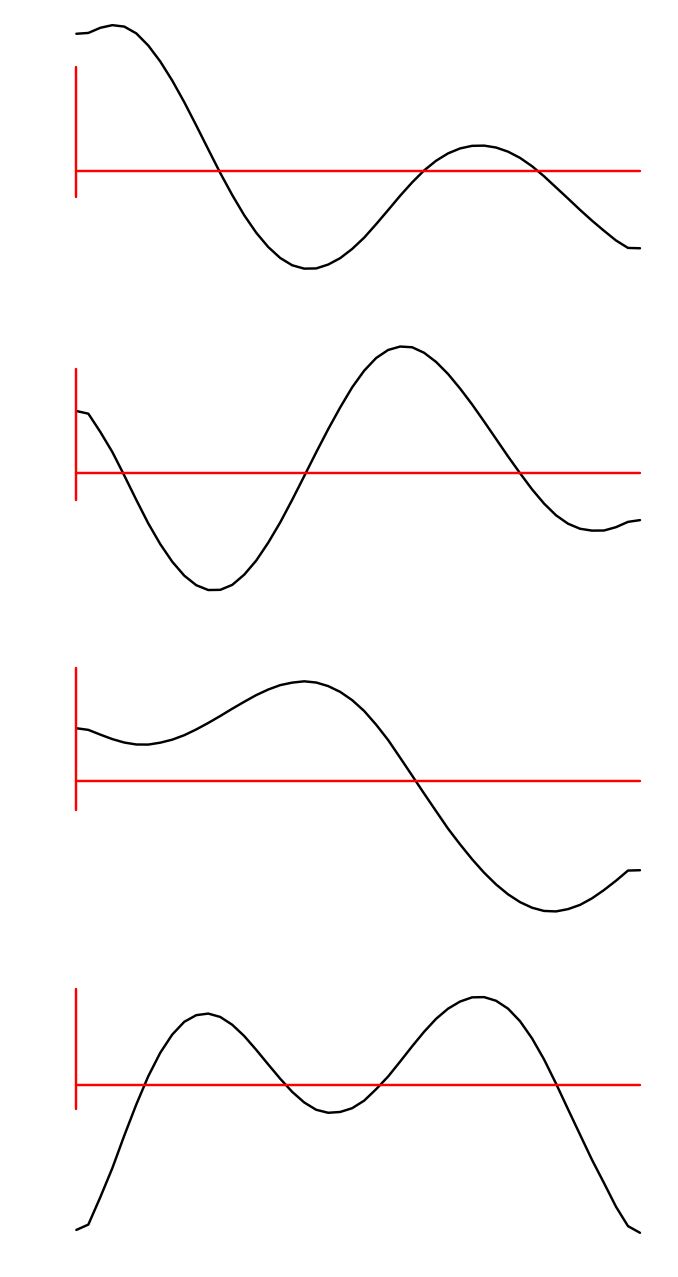

In [10]:
s=np.linspace(0,1,48)

num_eigs = 4
fig, axarr = plt.subplots(4,1,figsize=(8,16))

for ii in range(num_eigs):
    axarr[ii].plot(s,eigvec_all[:,ii],'k')
    axarr[ii].plot(s,np.zeros(len(s)),'r-')
    axarr[ii].plot(np.zeros(len(s)),np.linspace(-0.05,0.2,len(s)),'r-')
    axarr[ii].set_axis_off()

We are going to omit 0 angles


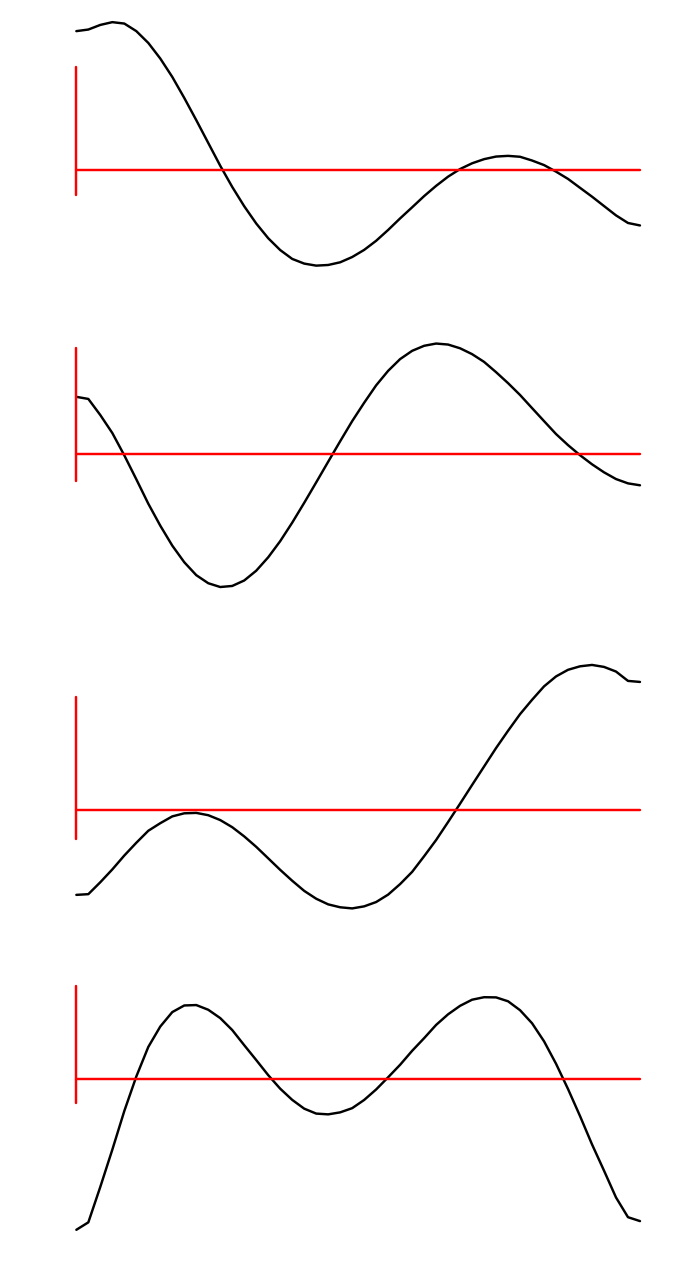

In [11]:
# Looking at eigenworms of single worm
eigval_one, eigvec_one = preworm.worm_covariance(angles_trun[0])
fig, axarr = plt.subplots(4,1,figsize=(8,16))

for ii in range(num_eigs):
    axarr[ii].plot(s,eigvec_one[:,ii],'k')
    axarr[ii].plot(s,np.zeros(len(s)),'r-')
    axarr[ii].plot(np.zeros(len(s)),np.linspace(-0.05,0.2,len(s)),'r-')
    axarr[ii].set_axis_off()

In [12]:
eigAmps = np.dot(eigvec_all.T,worms_angleArray.T)

In [13]:
au = util.eig_normalization(eigAmps)

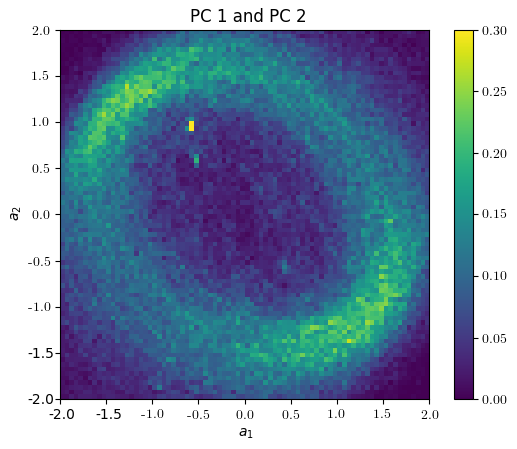

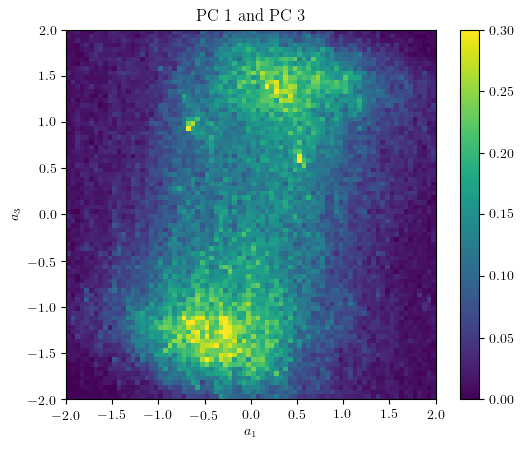

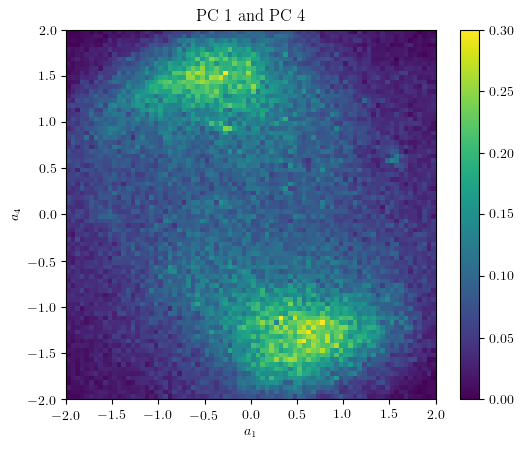

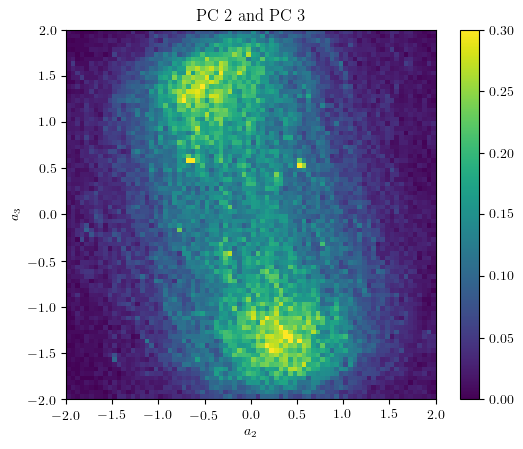

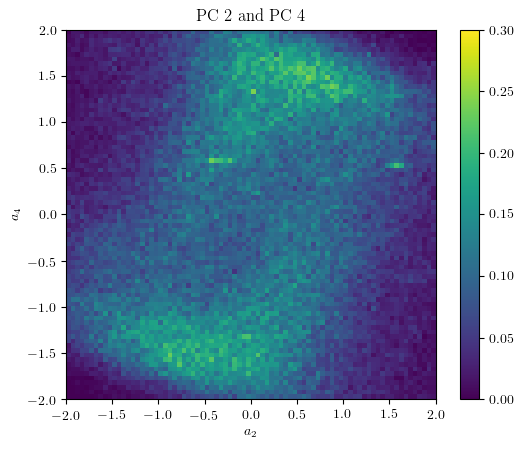

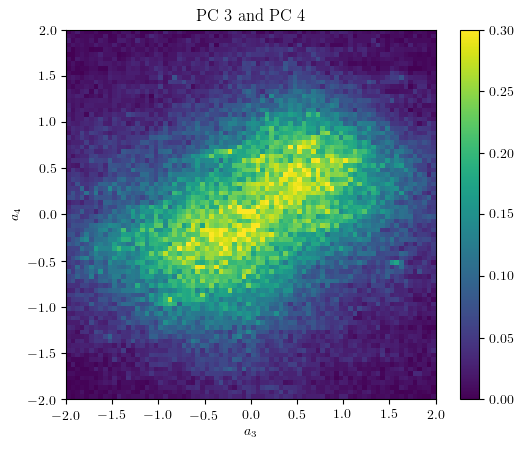

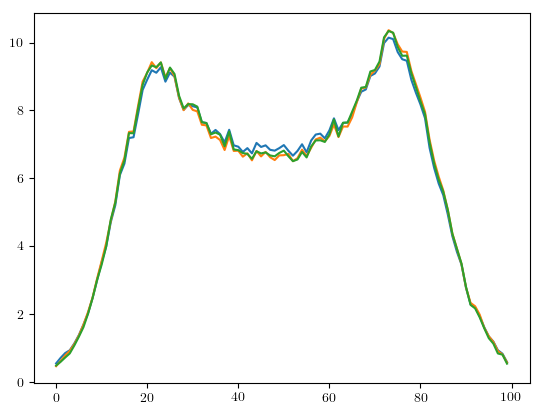

In [15]:
mpl.style.use('default')
tplot.plot_joint_pd_au(au)

In [16]:
from itertools import combinations
def fig1c(au):
    """
    Plot joint pd of au values
    """
    from matplotlib import rc, rcParams
    import matplotlib
    from mpl_toolkits.axes_grid1 import AxesGrid
    plt.rc('text', usetex=True)
    plt.rc('font', family='times')
    rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
    matplotlib.rcParams.update({'font.size': 10})
       
    fig = plt.figure(figsize=(4, 6))
    grid = AxesGrid(fig, 111,
                direction='column',
                nrows_ncols=(3, 2),
                axes_pad=0.55,
                share_all=False,
                label_mode=all,
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.00,
                )

    numBins = 100
    bins = np.linspace(-2, 2,numBins+1)
    marginals = []
    num_pcs = 4
    pc_values = np.arange(num_pcs)
    
    for index, pairs in enumerate(combinations(pc_values,2)):
        pc1, pc2 = pairs    
        H, xedges, yedges= np.histogram2d(au[pc1],au[pc2],normed=True,bins=bins)
        ax = grid[index]
        #ax =  axarr[index % 3,index // 3]
        img = ax.imshow(H, interpolation='nearest', clim=(0.0, 0.3) ,\
                   extent=[-2, 2, -2, 2] ,cmap='Reds',vmin=0,vmax=0.3)
        tick_vals= np.linspace(-2,2,3)
        ax.set_xticks(tick_vals)
        ax.set_yticks(tick_vals)
        ax.set_xticklabels(list(map(str,tick_vals)))
        ax.set_yticklabels(list(map(str,tick_vals)))
        ax.set_aspect('equal')
        ax.set_xlabel(r'$a_{%d}$'%(pc1+1))
        ax.set_ylabel(r'$a_{%d}$'%(pc2+1))
    cbar = grid.cbar_axes[0].colorbar(img)
    cbar.ax.set_xticks(np.linspace(0,0.3,3))
    plt.subplots_adjust(hspace=0.3)
    #plt.savefig('figures/all_aus_reds.eps')
    return

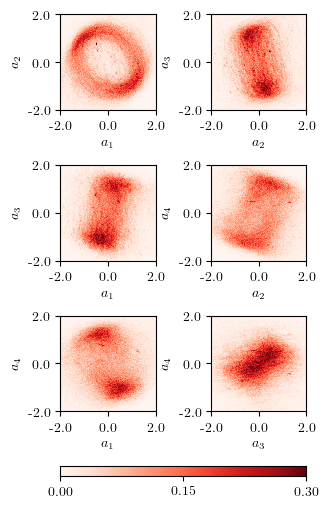

In [17]:
fig1c(au)